<a href="https://colab.research.google.com/github/Erick88santos/Dataset_shark_anotation/blob/main/Yolo_Detection_Shark_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introdução
Este notebook usa Ultralytics para treinar modelos de detecção de objetos YOLO11, YOLOv8 ou YOLOv5 com um conjunto de dados personalizado. Assim usado, para analisar o [Drone Shark Detection Dataset](https://www.kaggle.com/datasets/erick88santos/drone-shark-detection-dataset).


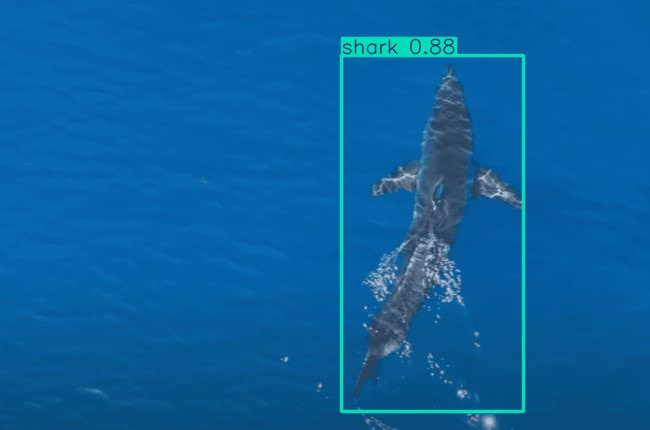


Modelo de detecção de doces YOLO personalizado em ação!

#### **Nota importante: Este notebook será atualizado continuamente para garantir que funcione com versões mais recentes do Ultralytics e do YOLO.**

## Trabalhando no Colab
O Colab fornece uma máquina virtual no seu navegador completa com um sistema operacional Linux, sistema de arquivos, ambiente Python e, o melhor de tudo, uma GPU gratuita. Instalaremos o PyTorch e o Ultralytics neste ambiente e os usaremos para treinar nosso modelo. Basta clicar no botão Play em seções de código neste notebook para executá-las na máquina virtual.

## Navegação
Para navegar neste notebook, use o índice na barra lateral esquerda para pular de seção para seção.

## Verifique a disponibilidade da GPU NVIDIA

Certifique-se de que você está usando uma máquina equipada com GPU indo para "Tempo de execução" -> "Alterar tipo de tempo de execução" na barra de menu superior e, em seguida, selecionando uma das opções de GPU na seção Acelerador de hardware. Clique em Reproduzir no bloco de código a seguir para verificar se a GPU NVIDIA está presente e pronta para treinamento.

In [1]:
!nvidia-smi

Sun Mar 23 18:49:44 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   51C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# 1. Reúna e rotule imagens de treinamento.

Antes de começarmos o treinamento, precisamos reunir e rotular imagens que serão usadas para treinar o modelo de detecção de objetos. Um bom ponto de partida para um modelo de prova de conceito são 200 imagens. As imagens de treinamento devem ter objetos aleatórios na imagem junto com os objetos desejados, e devem ter uma variedade de fundos e condições de iluminação.

#### Existem algumas opções para reunir imagens:

Crie um conjunto de dados personalizado tirando suas próprias fotos dos objetos e rotulando-os (isso normalmente resulta no melhor desempenho)
Encontre um conjunto de dados pré-fabricado de fontes como Roboflow Universe, Kaggle ou Google Images V7
Se você quiser criar seu próprio conjunto de dados, existem várias ferramentas disponíveis para rotular imagens. Uma boa opção é o Label Studio, uma ferramenta de rotulagem gratuita e de código aberto que tem um fluxo de trabalho simples, ao mesmo tempo em que fornece recursos para recursos mais avançados.


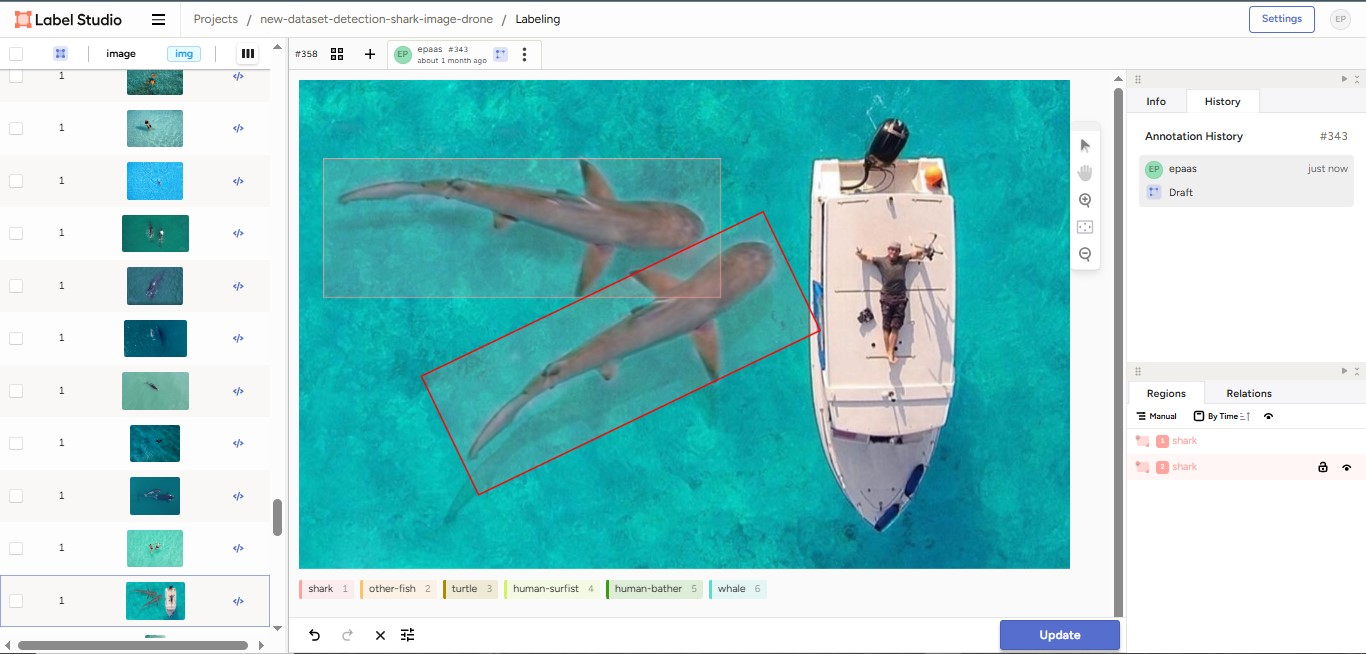


Exemplo de uma imagem de tubarão rotulada com o Label Studio.

Se você usou o Label Studio para rotular e exportar as imagens, elas serão exportadas em um arquivo project.zip que contém o seguinte:

- Uma pasta `images` contendo as imagens.

- Uma pasta `labels` contendo as etiquetas no formato de anotação YOLO.

- Um arquivo `classes.txt` labelmap que contém todas as classes.

- Um arquivo `notes.json` que contém informações específicas do Label Studio (este arquivo pode ser ignorado)
Se você obteve seu conjunto de dados de outra fonte (como Roboflow Universe) ou usou outra ferramenta para rotular seu conjunto de dados, certifique-se de que os arquivos estejam organizados na mesma estrutura de pastas.

Se você obteve seu conjunto de dados de outra fonte (como o Roboflow Universe) ou usou outra ferramenta para rotular seu conjunto de dados, certifique-se de que os arquivos estejam organizados na mesma estrutura de pastas.

<p align=center>
<img src="https://raw.githubusercontent.com/EdjeElectronics/Train-and-Deploy-YOLO-Models/refs/heads/main/doc/zipped-data-example.png" height=""><br>
</p>

Depois de construir seu conjunto de dados, colocá-lo na estrutura de arquivo mostrada acima e compactado em `data.zip`, você estará pronto para prosseguir para a próxima etapa.

**Carregar pelo Google Colab**

Carregue o arquivo `data.zip` para a instância do Google Colab clicando no ícone "Arquivos" no lado esquerdo do navegador e, em seguida, no ícone "Carregar para armazenamento de sessão". Selecione a pasta zip para carregá-lo.

<p>
<br>
<img src="https://raw.githubusercontent.com/EdjeElectronics/Train-and-Deploy-YOLO-Models/refs/heads/main/doc/upload-colab-files.png" height="240">
</p>


Utilize o scrip abaixo para descompactar o arquivo e enviá-lo para o caminho desejado.

In [2]:
# Unzip images to a custom data folder
!unzip -q /content/data.zip -d /content/custom_data

O Ultralytics requer uma estrutura de pasta específica para armazenar dados de treinamento para modelos. O Ultralytics requer uma estrutura de pasta específica para armazenar dados de treinamento para modelos. A pasta raiz é chamada de "dados". Dentro dela, há duas pastas principais:

* **Treinamento**: Essas são as imagens reais usadas para treinar o modelo. Em uma época de treinamento, cada imagem no conjunto de treinamento é passada para a rede neural. O algoritmo de treinamento ajusta os pesos da rede para ajustar os dados nas imagens.

* **Validação**: Essas imagens são usadas para verificar o desempenho do modelo no final de cada época de treinamento.

Em cada uma dessas pastas há uma pasta "imagens" e uma pasta "rótulos", que contêm os arquivos de imagem e os arquivos de anotação, respectivamente.

Esse script Python que criará automaticamente a estrutura de pasta necessária e moverá aleatoriamente 90% do conjunto de dados para a pasta "train" e 10% para a pasta "validation". Execute o seguinte bloco de código para baixar e executar o script.

In [3]:
!wget -O /content/train_val_split.py https://raw.githubusercontent.com/EdjeElectronics/Train-and-Deploy-YOLO-Models/refs/heads/main/utils/train_val_split.py

# TO DO: Improve robustness of train_val_split.py script so it can handle nested data folders, etc
!python train_val_split.py --datapath="/content/custom_data" --train_pct=0.9

--2025-03-23 18:53:19--  https://raw.githubusercontent.com/EdjeElectronics/Train-and-Deploy-YOLO-Models/refs/heads/main/utils/train_val_split.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3203 (3.1K) [text/plain]
Saving to: ‘/content/train_val_split.py’

/content/train_val_ 100%[===================>]   3.13K  --.-KB/s    in 0s      

2025-03-23 18:53:19 (57.1 MB/s) - ‘/content/train_val_split.py’ saved [3203/3203]

Created folder at /content/data/train/images.
Created folder at /content/data/train/labels.
Created folder at /content/data/validation/images.
Created folder at /content/data/validation/labels.
Number of image files: 293
Number of annotation files: 293
Images moving to train: 263
Images moving to validation: 30


# Requisitos de instalação (Ultralytics)

Em seguida, instalaremos a biblioteca Ultralytics nesta instância do Google Colab. Esta biblioteca Python será usada para treinar o modelo YOLO.

In [4]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.8/949.8 kB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 106.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

Há uma última etapa antes de executarmos o treinamento: precisamos criar o arquivo YAML de configuração de treinamento do Ultralytics. Este arquivo especifica a localização dos seus dados de treinamento e validação, e também define as classes do modelo. Um modelo de arquivo de configuração de exemplo está disponível [aqui](https://github.com/ultralytics/ultralytics/blob/main/ultralytics/cfg/datasets/coco128.yaml).

Execute o bloco de código abaixo para gerar automaticamente um arquivo de configuração `data.yaml`. Certifique-se de ter um arquivo labelmap localizado em `custom_data/classes.txt`. Se você usou o Label Studio ou um dos meus conjuntos de dados pré-fabricados, ele já deve estar presente. Se você montou o conjunto de dados de outra maneira, talvez seja necessário criar manualmente o arquivo `classes.txt` (veja [aqui](https://github.com/EdjeElectronics/Train-and-Deploy-YOLO-Models/blob/main/doc/classes.txt) para ver um exemplo de como ele é formatado).

In [5]:
# Python function to automatically create data.yaml config file
# 1. Reads "classes.txt" file to get list of class names
# 2. Creates data dictionary with correct paths to folders, number of classes, and names of classes
# 3. Writes data in YAML format to data.yaml

import yaml
import os

def create_data_yaml(path_to_classes_txt, path_to_data_yaml):

  # Read class.txt to get class names
  if not os.path.exists(path_to_classes_txt):
    print(f'classes.txt file not found! Please create a classes.txt labelmap and move it to {path_to_classes_txt}')
    return
  with open(path_to_classes_txt, 'r') as f:
    classes = []
    for line in f.readlines():
      if len(line.strip()) == 0: continue
      classes.append(line.strip())
  number_of_classes = len(classes)

  # Create data dictionary
  data = {
      'path': '/content/data',
      'train': 'train/images',
      'val': 'validation/images',
      'nc': number_of_classes,
      'names': classes
  }

  # Write data to YAML file
  with open(path_to_data_yaml, 'w') as f:
    yaml.dump(data, f, sort_keys=False)
  print(f'Created config file at {path_to_data_yaml}')

  return

# Define path to classes.txt and run function
path_to_classes_txt = '/content/custom_data/classes.txt'
path_to_data_yaml = '/content/data.yaml'

create_data_yaml(path_to_classes_txt, path_to_data_yaml)

print('\nFile contents:\n')
!cat /content/data.yaml

Created config file at /content/data.yaml

File contents:

path: /content/data
train: train/images
val: validation/images
nc: 6
names:
- human-bather
- human-surfist
- other-fish
- shark
- turtle
- whale


In [6]:
!yolo detect train data=/content/data.yaml model=yolo11s.pt epochs=60 imgsz=640

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
100% 18.4M/18.4M [00:00<00:00, 161MB/s]
Ultralytics 8.3.94 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11s.pt, data=/content/data.yaml, epochs=60, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=Fal

# 5.&nbsp;Modelo de treinamento

## 5.1 Parâmetros de treinamento
Agora que os dados estão organizados e o arquivo de configuração foi criado, estamos prontos para começar o treinamento! Primeiro, há alguns parâmetros importantes para decidir. Visite meu artigo sobre [Treinando modelos YOLO localmente](https://www.ejtech.io/learn/train-yolo-models) para saber mais sobre esses parâmetros e como escolhê-los.

**Arquitetura e tamanho do modelo (`model`):**

Existem vários tamanhos de modelos YOLO11 disponíveis para treinar, incluindo `yolo11n.pt`, `yolo11s.pt`, `yolo11m.pt`, `yolo11l.pt` e `yolo11xl.pt`. Modelos maiores rodam mais devagar, mas têm maior precisão, enquanto modelos menores rodam mais rápido, mas têm menor precisão. Fiz um breve vídeo no YouTube que compara o desempenho de diferentes modelos YOLO em um Raspberry Pi 5 e um laptop com uma GPU RTX 4050, [confira aqui para ter uma ideia da precisão de velocidade](https://youtu.be/_WKS4E9SmkA). Se você não tem certeza de qual tamanho de modelo usar, `yolo11s.pt` é um bom ponto de partida.

Você também pode treinar modelos YOLOv8 ou YOLOv5 substituindo `yolo11` por `yolov8` ou `yolov5`.


**Número de épocas (`epochs`)**

Em aprendizado de máquina, uma "época" é uma única passagem pelo conjunto de dados de treinamento completo. Definir o número de épocas determina por quanto tempo o modelo será treinado. A melhor quantidade de épocas a serem usadas depende do tamanho do conjunto de dados e da arquitetura do modelo. Se seu conjunto de dados tiver menos de 200 imagens, um bom ponto de partida é 60 épocas. Se seu conjunto de dados tiver mais de 200 imagens, um bom ponto de partida é 40 épocas.

**Resolução (`imgsz`)**

A resolução tem um grande impacto na velocidade e precisão do modelo: um modelo de resolução mais baixa terá maior velocidade, mas menos precisão. Os modelos YOLO são normalmente treinados e inferidos em uma resolução de 640x640. No entanto, se você quiser que seu modelo seja executado mais rápido ou souber que trabalhará com imagens de baixa resolução, tente usar uma resolução mais baixa, como 480x480.

O algoritmo de treinamento analisará as imagens nos diretórios de treinamento e validação e, em seguida, iniciará o treinamento do modelo. No final de cada época de treinamento, o programa executa o modelo no conjunto de dados de validação e relata o mAP, a precisão e a recuperação resultantes. Conforme o treinamento continua, o mAP geralmente deve aumentar a cada época. O treinamento terminará quando passar pelo número de épocas especificado por `epochs`.

> **NOTA:** Certifique-se de permitir que o treinamento seja executado até a conclusão, porque um otimizador é executado no final do treinamento que remove camadas desnecessárias do modelo.

Os melhores pesos do modelo treinado serão salvos em `content/runs/detect/train/weights/best.pt`. Informações adicionais sobre o treinamento são salvas na pasta `content/runs/detect/train`, incluindo um arquivo `results.png` que mostra como a perda, a precisão, a recuperação e o mAP progrediram em cada época.


# Teste do modelo

O modelo foi treinado; agora é hora de testá-lo! Os comandos abaixo executam o modelo nas imagens na pasta de validação e então exibem os resultados para as primeiras 10 imagens. Esta é uma boa maneira de confirmar se seu modelo está funcionando conforme o esperado. Clique em Play nos blocos abaixo para ver como seu modelo se sai.

In [7]:
!yolo detect predict model=runs/detect/train/weights/best.pt source=data/validation/images save=True

Ultralytics 8.3.94 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,415,122 parameters, 0 gradients, 21.3 GFLOPs

image 1/30 /content/data/validation/images/0370db4c-shark-near-shorejpg-4855d9f3aca50404.jpg: 416x640 1 shark, 60.6ms
image 2/30 /content/data/validation/images/1bc88bf7-hqdefault.jpg: 480x640 3 sharks, 50.4ms
image 3/30 /content/data/validation/images/3c527ba1-img_30.jpg: 448x640 1 shark, 56.3ms
image 4/30 /content/data/validation/images/42320b79-img_92.jpg: 416x640 1 human-bather, 2 sharks, 12.7ms
image 5/30 /content/data/validation/images/4b415d67-shark-attack-1.jpg: 384x640 6 sharks, 57.3ms
image 6/30 /content/data/validation/images/4bb439b4-hqdefault.jpg: 480x640 1 shark, 13.3ms
image 7/30 /content/data/validation/images/4eab881a-gltcfv08spa31.jpg: 640x480 1 shark, 50.3ms
image 8/30 /content/data/validation/images/54b2e180-screenshot-2023-11-15-at-61432-am.png: 448x640 1 shark, 13.1ms
image 9/30 /content/data/validat

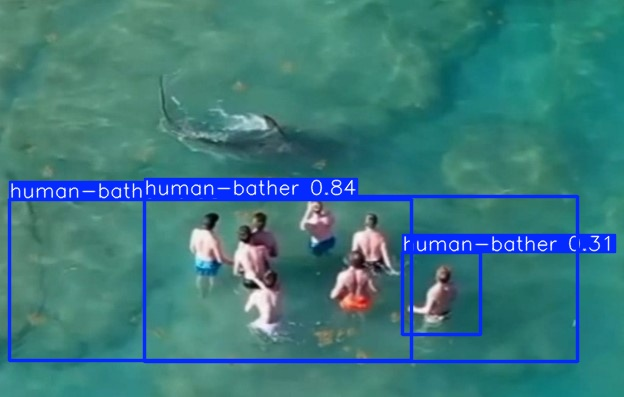

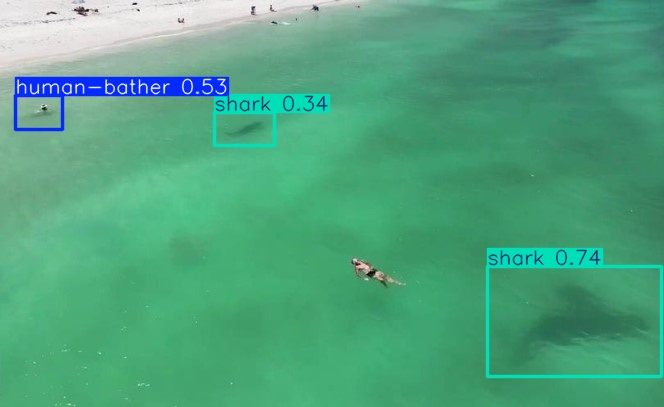

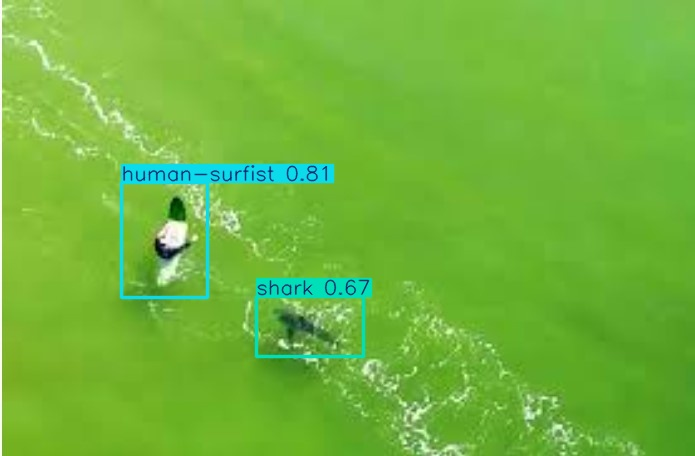

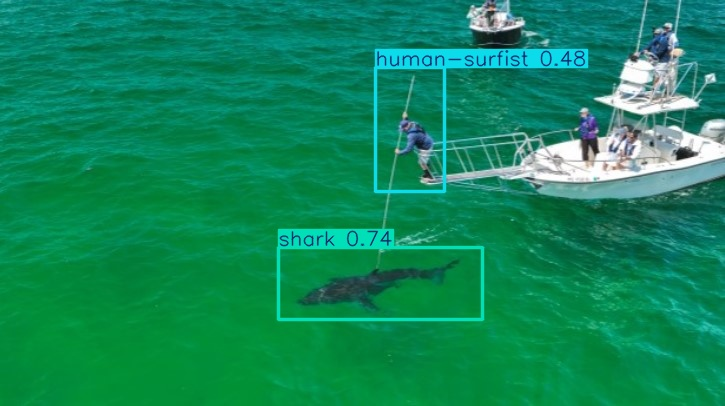

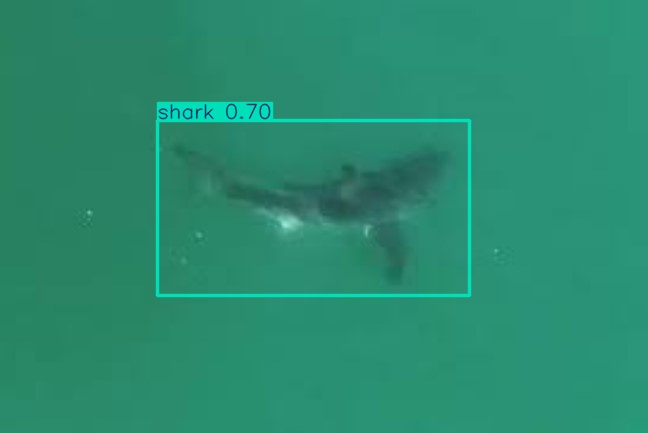

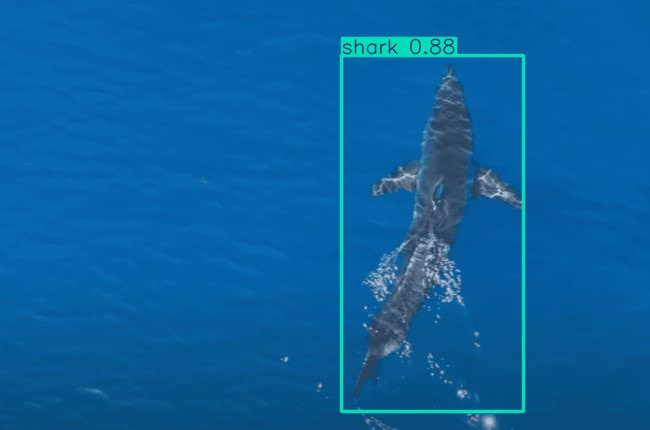

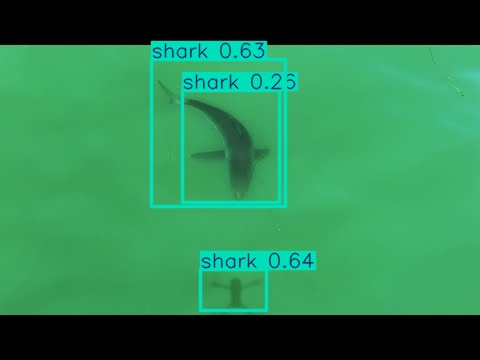

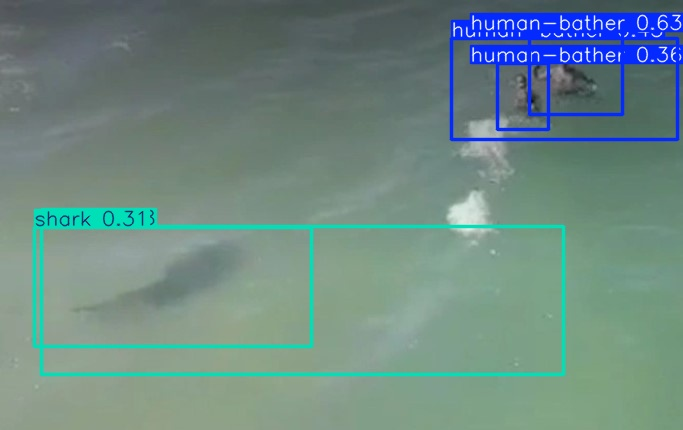

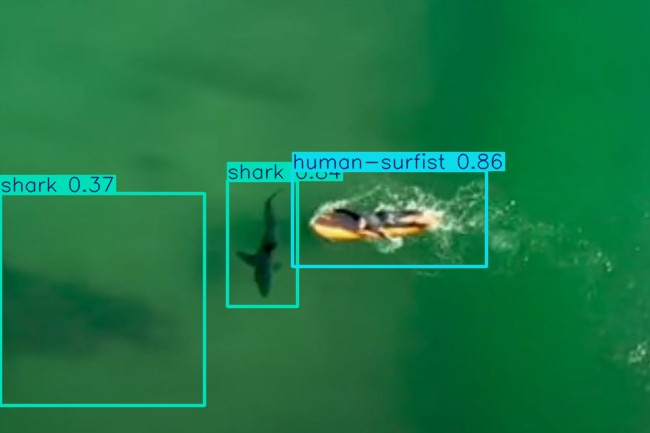

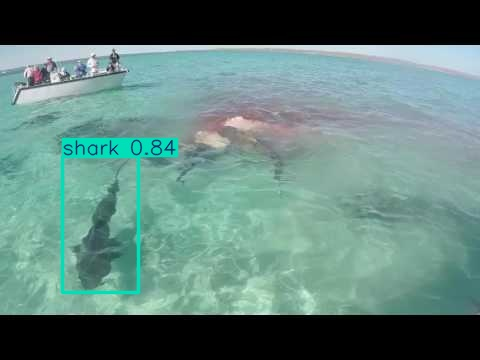

In [8]:
import glob
from IPython.display import Image, display
for image_path in glob.glob(f'/content/runs/detect/predict/*.jpg')[:10]:
  display(Image(filename=image_path, height=400))
  print('\n')

# Crie a pasta "my_model" para armazenar pesos do modelo e resultados do treinamento

In [ ]:
# Create "my_model" folder to store model weights and train results
!mkdir /content/my_model
!cp /content/runs/detect/train/weights/best.pt /content/my_model/my_model.pt
!cp -r /content/runs/detect/train /content/my_model

# Zip into "my_model.zip"
%cd my_model
!zip /content/my_model.zip my_model.pt
!zip -r /content/my_model.zip train
%cd /content